# Import modules

In [2]:
from sunpy.net import Fido, attrs as a
import sunpy.io.cdf as cdf
from sunpy.timeseries import GenericTimeSeries
import sunpy_soar
import numpy as np
import analysis_helpers as h

c:\Users\Ronan\Anaconda3\envs\belfast_data\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the data

In [3]:
# Create search attributes
instrument = a.Instrument('MAG')
time = a.Time('2022-02-08', '2022-03-05')
level = a.Level(2)
product = a.soar.Product('MAG-RTN-NORMAL-1-MINUTE')

# Do search
result = Fido.search(time & level & product)
# print(result)


In [4]:
# Download files
files = Fido.fetch(result)

Files Downloaded: 100%|██████████| 25/25 [00:01<00:00, 15.94file/s]


In [5]:
import cdflib
import pandas as pd

data = pd.DataFrame()

for file in files:
    temp_df = h.cdf2df(file)
    data = pd.concat([data, temp_df])
    data.sort_index(inplace=True)

Exception ignored in: <function CDF.__del__ at 0x000001BFC36784C0>
Traceback (most recent call last):
  File "c:\Users\Ronan\Anaconda3\envs\belfast_data\lib\site-packages\cdflib\cdfread.py", line 152, in __del__
    os.remove(self.temp_file)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\Ronan\\AppData\\Local\\Temp\\tmpj8kd8m04.cdf'
Exception ignored in: <function CDF.__del__ at 0x000001BFC36784C0>
Traceback (most recent call last):
  File "c:\Users\Ronan\Anaconda3\envs\belfast_data\lib\site-packages\cdflib\cdfread.py", line 152, in __del__
    os.remove(self.temp_file)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\Ronan\\AppData\\Local\\Temp\\tmpav5fv_gv.cdf'
Exception ignored in: <function CDF.__del__ at 0x000001BFC36784C0>
Traceback (most recent call last):
  File "c:\Users\Ronan\Anaconda3\envs\belfast_data\lib\site-packages\cdflib\

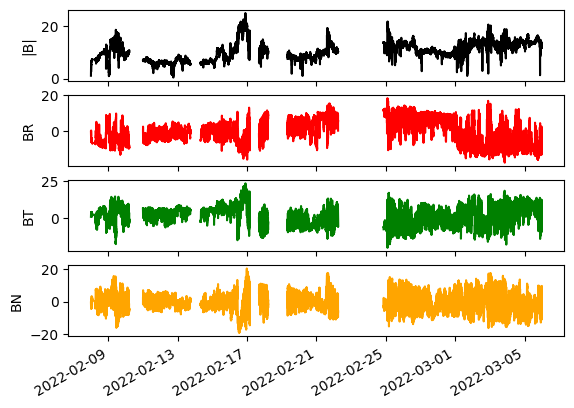

In [6]:
#just plot the data to check its ok
import matplotlib.pyplot as plt
fig, axs = plt.subplots(4,1,sharex=True)

axs[0].plot(data['|B|'], color = 'black')
axs[0].set_ylabel('|B|')
axs[1].plot(data['BR'], color = 'red')
axs[1].set_ylabel('BR')
axs[2].plot(data['BT'], color = 'green')
axs[2].set_ylabel('BT')
axs[3].plot(data['BN'], color = 'orange')
axs[3].set_ylabel('BN')

fig.autofmt_xdate()

# Magnetic Polarity

The interplanetary magnetic field can either point towards (negative polarity) or away from the Sun (positive polarity).

At solar minimum there are two very clearly defined "magnetic sectors", so by knowing which one the spacecraft is in we can map the structure of the "Heliospheric Current Sheet" (HCS) that lies between the two polarities.

<center>
<img src="polarity.gif" height="400"/>
</center>





# Defining polarity

The solar wind leaves the Sun radially, and travels out into the heliosphere. However, the Sun is spinning at a rate of $14^{\circ}$/day meaning that the solar wind creates a spiral pattern, the Parker spiral.

<center>
<img src="parker_spiral.gif" height="400"/>
</center>

From the "Frozen-in theorem", the magnetic field will follow the plasma in the solar wind, therefore, the interplanetary magnetic field does not point radially away from the Sun. So how do we define the magnetic polarity?

The Parker spiral angle is given by: $$\theta = \arctan(\frac{- r \Omega}{V_{sw}})$$

,which depends on the spacecraft distance, $r$, and solar wind speed, $V_{sw}$.

So we can define the polarity as within $\pm 45^{\circ}$ of the nominal Parker spiral direction, as demonstrated here:

<center>
<img src="polarity_diagram.png" width="400"/>
</center>



# Adding trajectory data

Before we can work out the Parker spiral angle, we need the distance of the spacecraft from the Sun.

We need to load the right SPICE kernels, which is not an easy task. I will use a package called astrospice, so it can be done automatically in the notebook.

In [7]:
import astrospice
from sunpy.coordinates import HeliographicCarrington
import astropy.units as u


#get the SPICE kernels
solo_kernels = astrospice.registry.get_kernels('solar orbiter', 'predict')
solo_kernel = solo_kernels[0]
solo_coverage = solo_kernel.coverage('SOLAR ORBITER')
print("SPICE kernels cover this time period: ", solo_coverage.iso)

# use every 30 mins for trajectory, then interpolate
times = data.index[::30]

#get the coordinates
coords = astrospice.generate_coords('SOLAR ORBITER', times)
carr_frame = HeliographicCarrington(observer="self")
carr_coords = coords.transform_to(carr_frame)

# have to make sure there is no wrapping in angles before I interpolate
lons = carr_coords.lon.to(u.degree).value
# find the break point

# keeps unwrapping until a longitude is a straight line, not wrapped around 360
while np.any(np.diff(lons) > 10):
    lons = h.unwrap_lons(lons)

# make a orbit dataframe that I can then interpolate and incorporate into data
orbit_df = pd.DataFrame(
    {
        "Radius": carr_coords.radius.to(u.au).value,
        "Carr_lon": lons,
        "Carr_lat": carr_coords.lat.to(u.degree).value,
    },
    index=times,
)

# drop columns if they already exist
if "Radius" in data.keys():
    data.drop(
        columns=["Radius", "Carr_lon", "Carr_lat"], inplace=True
    )
    
#re-index to data
orbit_df = orbit_df.reindex(data.index)
# add the orbit variables in
for key in orbit_df.keys():
    data[key] = orbit_df[key]

#interpolate to fill in the NaNs
# I don't want to interpolate the gaps in magnetic field
data[['Radius', 'Carr_lon', 'Carr_lat']] = data[['Radius', 'Carr_lon', 'Carr_lat']].interpolate(method="time")



c:\Users\Ronan\Anaconda3\envs\belfast_data\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.18file/s]
c:\Users\Ronan\Anaconda3\envs\belfast_data\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
c:\Users\Ronan\Anaconda3\envs\belfast_data\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


SPICE kernels cover this time period:  ['2020-02-10 04:55:49.670' '2030-11-20 12:48:13.511']


In [32]:
#guess a speed for now, in reality you would get a speed from PAS
data['V'] = 350

tolerance = 45
data = h.add_polarity2df(data, ds_period = '12H',tolerance=tolerance)

In [26]:

#angle of magnetic field in R-T plane
mag_angle = np.arctan2(data['BT'],data['BR']) *180/np.pi
# make the angles go from 0 -> 360
mag_angle[mag_angle<0] += 360
data['mag_angle'] = mag_angle

data['PS_angle'] = h.PS_angle(data['Radius'].values*u.au, data['V'].values*u.km/u.s)

Text(0, 0.5, 'Polarity')

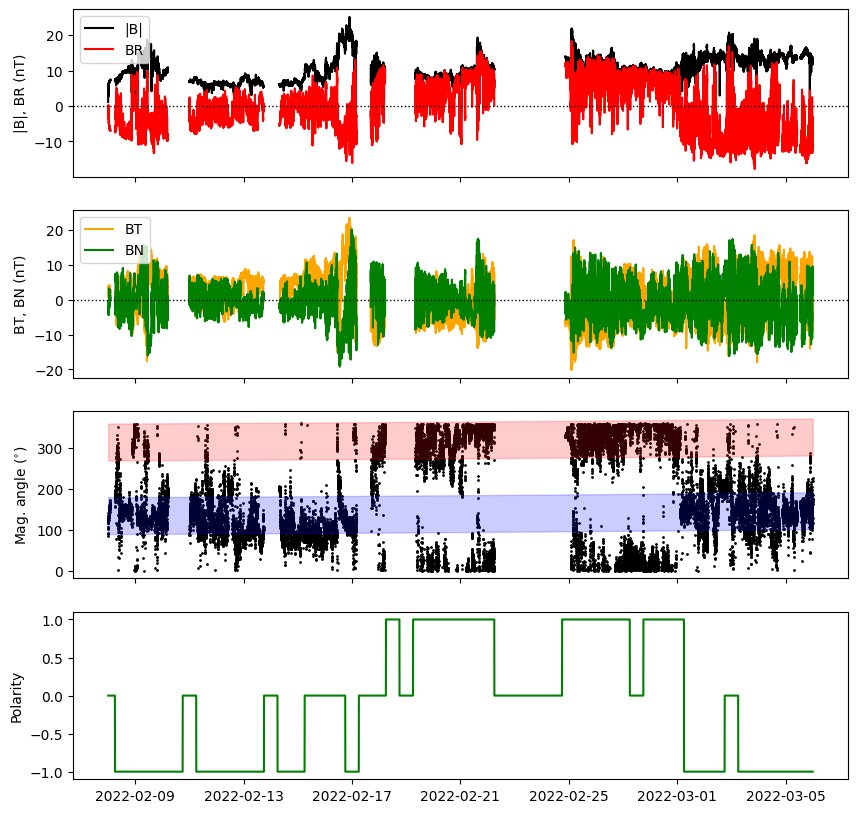

In [33]:
fig, axs = plt.subplots(4, sharex = True, figsize = (10,10))
axs[0].plot(data['|B|'], color = 'black', label = '|B|')
axs[0].plot(data['BR'], color = 'red', label = 'BR')
axs[0].legend(loc = 'upper left')

axs[1].plot(data['BT'], color = 'orange', label = 'BT')
axs[1].plot(data['BN'], color = 'green', label = 'BN')
axs[1].legend(loc = 'upper left')

axs[0].set_ylabel('|B|, BR (nT)')
axs[1].set_ylabel('BT, BN (nT)')

for ax in axs[:2]:
    ax.axhline(0, color = 'black', lw = 1, ls = 'dotted')

axs[2].scatter(data.index, data['mag_angle'], color = 'black', s = 1)
axs[2].fill_between(data.index, data['PS_angle'] +tolerance, data['PS_angle'] -tolerance, color = 'red', alpha = 0.2)
axs[2].fill_between(data.index, data['PS_angle'] -180 +tolerance, data['PS_angle'] -180 -tolerance, color = 'blue', alpha = 0.2)
axs[2].set_ylabel('Mag. angle ($^{\circ}$)')


axs[3].plot(data['polarity'], color = 'green')
axs[3].set_ylabel('Polarity')

# Carrington Map

Easier to see the magnetic structure when we plot in the Carrington frame. This is one where the Sun's rotation is accounted for, so the solar wind Parker spiral pattern is frozen. Therefore, if we plot the polarity as colour, we can see the structure ourselves.

(0.0, 1.0, 0.0, 1.0)

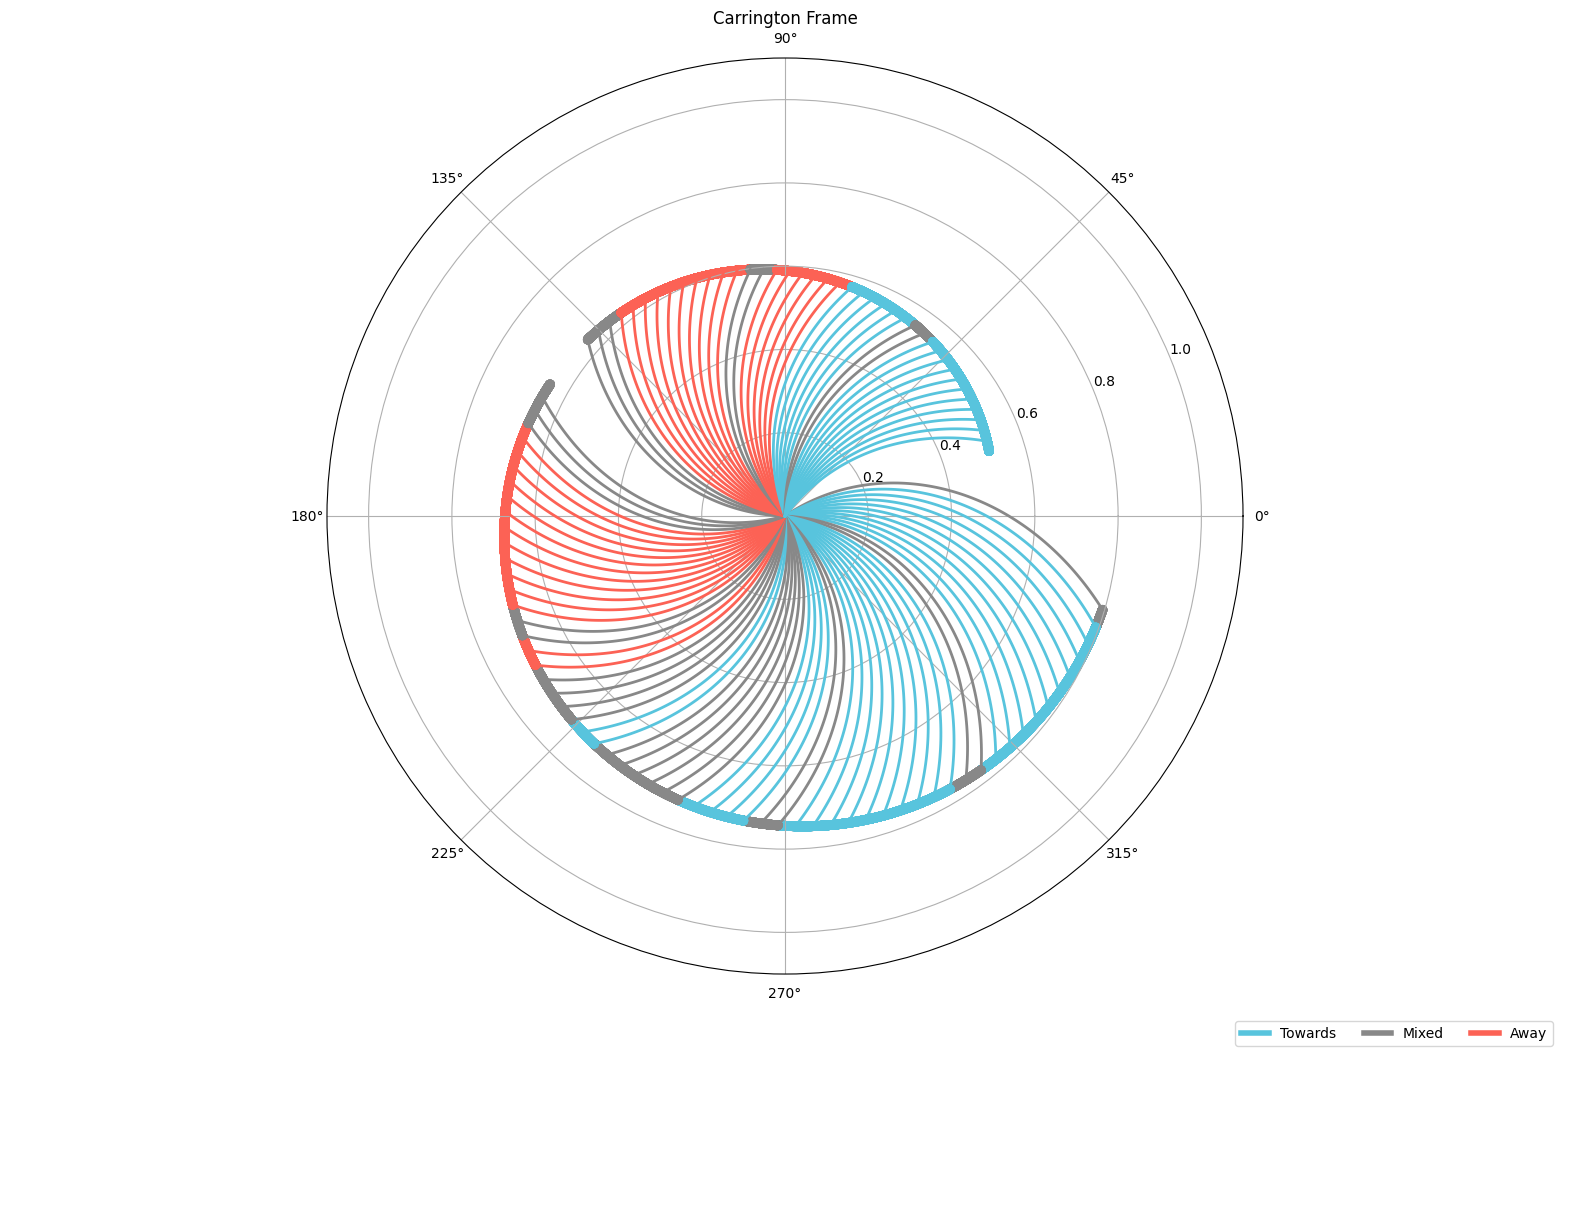

In [37]:
fig = plt.figure(figsize = (20,15))
gs = fig.add_gridspec(5, 1)
ax_polar = fig.add_subplot(gs[:-1, 0], projection = 'polar')
cax = fig.add_subplot(gs[-1, 0])

data[['polarity']] = data[['polarity']].fillna(0)
cmap = None
solo_c = data["polarity"].values.astype('object')
solo_c[solo_c==1] = '#FC6255'
solo_c[solo_c==-1] = '#58C4DD'
solo_c[solo_c==0] = '#888888'


# Carrington Frame
cb = ax_polar.scatter(data["Carr_lon"] * np.pi/180, data['Radius'], c = solo_c)

ax_polar.set_ylim(0, 1.1)
ax_polar.set_title("Carrington Frame")

#add parker spirals every 12 hours
slice_every = 6*60
for lon, radius, color in zip(data['Carr_lon'].values[::slice_every], data['Radius'].values[::slice_every], solo_c[::slice_every]):
    # make some radii to draw spiral with
    r = np.linspace(0,radius, 100)
    # work out a shift in longitude for each r
    omega = (14.713 * np.pi / 180.0) / (24 * 3600)
    spiral_lon = lon*np.pi/180 + ((radius - r)*1.5e8 * omega / (400))
    ax_polar.plot(spiral_lon, r, color = color, lw = 2)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='#58C4DD', lw=4, label = 'Towards'),
            Line2D([0], [0], color='#888888', lw=4, label = 'Mixed'),
            Line2D([0], [0], color='#FC6255', lw=4, label = 'Away')]
cax.legend(handles=custom_lines, ncol=3)
cax.axis('off')

<center>
<img src="parker_spiral.gif" height="400"/>
</center>